<a href="https://colab.research.google.com/github/chinglam4350/3220Asm/blob/main/lihkg_stories.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
! pip install keras_bert

In [2]:
import numpy as np
import gc
import unicodedata
from sklearn.metrics import precision_score,recall_score,f1_score
from keras_bert import load_trained_model_from_checkpoint, Tokenizer
from keras.layers import *
from keras.callbacks import *
from keras.models import Model
from keras.optimizers import Adam
from keras.utils import to_categorical
import matplotlib.pyplot as plt

In [ ]:
from google.colab import drive
import pickle
import pandas as pd

# google drive setup
drive.mount("/content/drive")
path = "/content/drive/My Drive/FYP/"

# pre-trained model path
config_path = path + 'chinese_roberta_wwm_large_ext_L-24_H-1024_A-16/bert_config.json'
checkpoint_path = path + 'chinese_roberta_wwm_large_ext_L-24_H-1024_A-16/bert_model.ckpt'
dict_path = path + 'chinese_roberta_wwm_large_ext_L-24_H-1024_A-16/vocab.txt'

# import datafile
train_df = pd.read_csv(path + "lihkg/train_stories.csv", names=['content','group'], skiprows=[0]).astype(str)
test_df = pd.read_csv(path + "lihkg/test_stories.csv", names=['content','group'], skiprows=[0]).astype(str)
valid_df = pd.read_csv(path + "lihkg/valid_stories.csv", names=['content','group'], skiprows=[0]).astype(str)

seq_len = 256
epochs = 5
lr = 1e-5

# convert data into format for model inputs
train_data = []
for line in train_df.itertuples():
  train_data.append((line.content[:seq_len-2], to_categorical(line.group, 5)))
train_data = np.array(train_data)

test_data = []
for line in train_df.itertuples():
  test_data.append((line.content[:seq_len-2], to_categorical(line.group, 5)))
test_data = np.array(test_data)

valid_data = []
for line in train_df.itertuples():
  valid_data.append((line.content[:seq_len-2], to_categorical(line.group, 5)))
valid_data = np.array(valid_data)

In [66]:
# build token dictionary
with open(dict_path, 'r', encoding='UTF8') as df:
  token_dict = {line.strip():index for index, line in enumerate(df)}
  
# override tokenizer to assure same length after tokenization (as original tokenizer will remove space)
class OurTokenizer(Tokenizer):
  def _tokenize(self, text):
    if not self._cased:
      text = unicodedata.normalize('NFD', text)
      text = ''.join([ch for ch in text if unicodedata.category(ch) != 'Mn'])
      text = text.lower()
    spaced = ''
    for ch in text:
      if self._is_punctuation(ch) or self._is_cjk_character(ch):
        spaced += ' ' + ch + ' '
      elif self._is_space(ch):
        spaced += ' ' +'[unused1]' + ' ' # use [unused1] to represent space
      elif ord(ch) == 0 or ord(ch) == 0xfffd or self._is_control(ch):
        continue
      else: 
        spaced += ch
    tokens = []
    for word in spaced.strip().split():
      tokens += self._word_piece_tokenize(word)
    return tokens

tokenizer = OurTokenizer(token_dict, cased=True)

In [67]:
# input dataset and output dataset with padding
def text_padding(data, padding=0):
  L = [len(d) for d in data]
  ML = max(L)
  return np.array([np.concatenate([d, [padding] * (ML - len(d))]) if len(d) < ML else d for d in data])

# in order to save memory
class DataGenerator:
  def __init__(self, data, batch_size=16, shuffle=True):
      self.data = data
      self.list_IDs = [idx for idx in range(len(self.data))]
      self.batch_size = batch_size
      self.shuffle = shuffle
      self.steps = len(self.list_IDs) // self.batch_size
      if len(self.list_IDs) % self.batch_size > 0: self.steps += 1

  # number of batches per epoch (steps)
  def __len__(self):
    return self.steps

  def __iter__(self):
    while True:
      if self.shuffle:
        np.random.shuffle(self.list_IDs)

      # generating matrices
      X1, X2, Y = [], [], []
      for idx in self.list_IDs:
        d = self.data[idx]
        text = d[0]
        indices, segments = tokenizer.encode(first=text)
        group = d[1]
        X1.append(indices) # token embeddings
        X2.append(segments) # segment embeddings
        Y.append([group]) # category
        if len(X1) == self.batch_size or idx == self.list_IDs[-1]:
          X1 = text_padding(X1)
          X2 = text_padding(X2)
          Y = text_padding(Y)
          yield [X1, X2], Y[:,0,:]
          [X1, X2, Y] = [], [], [] # reset

In [87]:
# sample data
'''
print('token embedding: ')
print(X1_test[0],'\n')
print('segments embedding: ')
print(X2_test[0],'\n')
print('group: ')
print(Y_test[0])
'''

token embedding: 
[  101  5654  6205  2511   939   148  8641  6919  7278  3199  6234  6222
  1850  3361  7278  3314   888   677  2136  3747  2551  6524   815   100
  1645  4506  2199  6724  4077  3021  6721  3021  6222  1850  2767  4922
  6721  5214  6207  6281  6524  5681  6524  5681  6207  4698   677  4705
  2339  3361  7278  5654   814  3312  6207  2864  2339  1059   815   100
  6274  2511   855  2339   676  6715  1755   939   153  5198  5681  3361
   815  1645  4684  7945  5681  3361   815  1645  4684   153  6207  2395
  6281   751  8558  2339   942 10075  2395  2982  6316  3538  1755  8287
  2960  4275  1059  2483  4684  1232  4959  1036   670  2483   975  2418
  4196  2526  1043 12322 10706  2483  5861  3017  2952  6316  8849 10788
  8409  4533  2768  6340  1645  3361  1367     1  6524  3169  2796     1
  3646  1645  2960  1961   942   854  1216   942   164  8782  8153  3017
  2952  3306   677   897  2156  2406  7952  8113  1645  8558  2406  1145
  7131   781  2395  2982  2339  3

In [68]:
bert_model = load_trained_model_from_checkpoint(
      config_path,
      checkpoint_path,
      trainable = True,
      seq_len = None,)

for l in bert_model.layers:
  l.trainable = True
  
x1_in = Input(shape=(None,))
x2_in = Input(shape=(None,))

x = bert_model([x1_in, x2_in])
x = Lambda(lambda x: x[:, 0])(x)
p = Dense(5, activation='softmax')(x)

model = Model([x1_in, x2_in], p)
model.compile(
    loss='categorical_crossentropy',
    optimizer=Adam(lr),
    metrics=['accuracy']
)
model.summary()

train_d = DataGenerator(train_data)
valid_d = DataGenerator(valid_data, shuffle=False)

checkpoint_filepath = path + 'lihkg/tmp/checkpoint.h5'
model_checkpoint_callback = ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_weights_only=True,
    monitor='val_accuracy',
    mode='max',
    save_best_only=True)

try:
  model.load_weights(checkpoint_filepath)
except:
  print("Checkpoint not found")

history = model.fit(
    train_d.__iter__(),
    steps_per_epoch= len(train_d),
    epochs=epochs,
    validation_data=valid_d.__iter__(),
    validation_steps= len(valid_d),
    callbacks=[model_checkpoint_callback]
)



Model: "model_40"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_27 (InputLayer)          [(None, None)]       0           []                               
                                                                                                  
 input_28 (InputLayer)          [(None, None)]       0           []                               
                                                                                                  
 model_39 (Functional)          (None, None, 1024)   324472832   ['input_27[0][0]',               
                                                                  'input_28[0][0]']               
                                                                                                  
 lambda_12 (Lambda)             (None, 1024)         0           ['model_39[0][0]']        

In [69]:
model.save(path + 'lihkg/saved_model/lihkg_stories_bert_model.h5')

In [70]:
X1_test, X2_test, Y_test = [],[],[]
list_IDs = [idx for idx in range(len(test_data))]
np.random.shuffle(list_IDs)
for idx in list_IDs:
  i, s = tokenizer.encode(first=test_data[idx][0])
  y = test_data[idx][1]
  i = i + [0] * (seq_len - len(i))
  s = s + [0] * (seq_len - len(s))
  X1_test.append(i)
  X2_test.append(s)
  Y_test.append(test_data[idx][1])

X1_test = np.asarray(X1_test)
X2_test = np.asarray(X2_test)
Y_test = np.asarray(Y_test)
y_pred = np.round(model.predict([X1_test, X2_test],batch_size=16))

67/67 [==============================] - 15s 101ms/step


In [79]:
print('precision: ', precision_score(Y_test,y_pred, average='weighted'))
print('recall: ', recall_score(Y_test,y_pred, average='weighted'))
print('f1: ', f1_score(Y_test,y_pred, average='weighted'))

precision:  0.9852399932388435
recall:  0.8673565380997178
f1:  0.9212426558794905


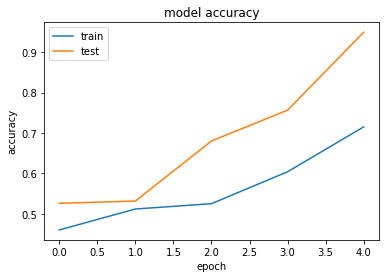

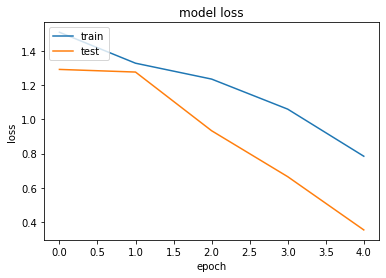

In [88]:
# summarize history for accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
